In [1]:
import os
import sys
import glob
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
#from numpy.random import seed
#seed(1)
#tf.random.set_seed(1)

### Dataset
First we download the dataset and call it as 'data'

Now we define utility functions to read data and labels and get data augmentation
>### Notes
>$glob$ is a built-in phyton mudole, it is a general term used to define techniques to match specified patterns according to rules related to Unix shell. More practical, it is used to retrieve files/pathnames matching a specified pattern. we can also use wildcards (*, ?, [ranges]) apart from exact string search to make path retrieval more simple.

>$os$ module in Python provides functions for interacting with the operating system. In particular $os.path$ module contains some useful functions on pathnames. The path parameters are either strings or bytes . These functions here are used for different purposes such as for merging, normalizing and retrieving path names in python. The method $os.path.join( , )$ has two arguments. The first is a path-like object representing a file system path, the second represents the path components to be joined. 

>$.h5$ is a format for scientific data. It contains multidimentional arrays

In [3]:
array_tau = np.load('ntuples/dataset_tau_MC20.npy')
np.random.shuffle(array_tau)
#array_tau = array_tau[:500000]
array_qcd = np.load('ntuples/dataset_fake_tau_MC20.npy')
np.random.shuffle(array_qcd)
#array_qcd = array_qcd[:500000]
print(array_tau.shape)#with cut at 1 Milion events
print(array_qcd.shape)

(4907514, 35, 11)
(1036878, 35, 11)


### Preproccessing

track variables

In [4]:
big_array = np.append(array_tau[:,:,:10],array_qcd[:,:,:10], axis=0)
print(big_array.shape)
tot_max = np.max( np.max(big_array,axis=1), axis=0)
tot_max = np.append(tot_max, 1)
tot_min = np.min( np.min(big_array,axis=1), axis=0)
tot_min = np.append(tot_min, 0)
big_array_scaled = (big_array - tot_min[:10])/(tot_max[:10] - tot_min[:10])

array_tau_scaled = (array_tau - tot_min)/(tot_max - tot_min)
array_qcd_scaled = (array_qcd - tot_min)/(tot_max - tot_min)
#print(array_tau_scaled[len(array_tau_scaled)-1,:])
#print(big_array_scaled[len(array_tau_scaled)-1,:])

comparison = array_tau_scaled[:,:,:10] == big_array_scaled[:len(array_tau_scaled),:]
equal_arrays = comparison.all()
print(equal_arrays) #Because of the cut, this will be False

(5944392, 35, 10)
True


Build test and train

In [5]:
train = {}
test = {}
n_nodes = 20

test_percentage = 18#%
test_len = math.floor(len(array_tau)*test_percentage/100)
coordinates = []
[coordinates.append([True, True, False, False, False, False, False, False, False, False, False]) for i in range( n_nodes ) ]
coordinates = np.reshape(np.array(coordinates), ( n_nodes, 11) )

test_len = 200000
test['features'] = array_tau_scaled[:test_len,:n_nodes]
test['features'] = np.append(test['features'], array_qcd_scaled[:test_len,:n_nodes], axis = 0)
test['points'] = np.reshape( test['features'][:,coordinates], ( len(test['features']), n_nodes, 2) )
test['label'] = np.ones(test_len)
test['label'] = np.append(test['label'],np.zeros(test_len), axis = 0)

train_len = 500000
train['features'] = array_tau_scaled[test_len:train_len+test_len,:n_nodes]
train['features'] = np.append(train['features'], array_qcd_scaled[test_len:train_len+test_len,:n_nodes], axis = 0)
train['points'] = np.reshape( train['features'][:,coordinates], ( len(train['features']), n_nodes, 2) )
train['label'] = np.ones( train_len )
train['label'] = np.append(train['label'], np.zeros(train_len), axis = 0)
print(train['label'][199999])

1.0


In [6]:
print(train['features'][0:3,17:19,10])

[[-10. -10.]
 [-10. -10.]
 [-10. -10.]]


In [7]:
print(train['points'].shape)
print(test['points'].shape)
print(train['features'].shape)
print(test['features'].shape)
print(train['label'].shape)
print(test['label'].shape)

(1000000, 20, 2)
(400000, 20, 2)
(1000000, 20, 11)
(400000, 20, 11)
(1000000,)
(400000,)


Here we shut down the Track-Flags

In [36]:
#print(train['features'][3,:,10])

a = train['features'][:,:,10] ==  3.
train['features'][a,10] =  1.
print(train['features'][7,:,10])

a = test['features'][:,:,10] ==  3.
test['features'][a,10] =  1.
print(test['features'][7,:,10])

[  1.   1.   1.   1.  -9.  -9.  -9.  -9.  -9.  -9.   5.   5.   5.   5.
   5.   5. -10. -10. -10. -10.]
[  1.   1.   1.   1.   1.   1.   1.   1.   1.  -9.   5.   5.   5.   5.
   5.   5. -10. -10. -10. -10.]


In [26]:
print(train['features'][:4,:,10])

[[  1.   1.   3.   3.   3.  -9.  -9.  -9.  -9.  -9.   5.   5.   5.   5.
    5.   5. -10. -10. -10. -10.]
 [  1.   1.   1.   3.   3.   3.   3.  -9.  -9.  -9.   5.   5.   5.   5.
    5.   5. -10. -10. -10. -10.]
 [  1.   1.   1.   3.   3.   3.   3.   3.   3.   3.   5.   5.   5.   5.
    5.   5. -10. -10. -10. -10.]
 [  1.   3.   3.   3.   3.   3.   3.   3.   3.   3.   5.   5.   5.   5.
    5.   5. -10. -10. -10. -10.]]


In [27]:
print(test['features'][:30,9:,10])

[[  3.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [ -9.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [ -9.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [ -9.   5.   5.   5. -10. -10. -10. -10. -10. -10. -10.]
 [ -9.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [ -9.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [ -9.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [ -9.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [ -9.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [  3.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [  3.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [  3.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [  3.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [  3.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [  3.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [ -9.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [  3.   5.   5.   5.   5.   5.   5. -10. -10. -10. -10.]
 [  3.   5.   

In [11]:
# funzioni per dataugmentation (random traslation, rotations, jitter delle pointlcoud)
def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud

def rotate_pointcloud(pointcloud):
    theta = np.pi*2 * np.random.uniform()
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    pointcloud[:,[0,2]] = pointcloud[:,[0,2]].dot(rotation_matrix) # random rotation (x,z)
    return pointcloud

def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud

def shuffle(dict_data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    shuffle_indices = np.arange( len(dict_data['points']))#Len data.points has to be the same for data.features and data.label
    np.random.shuffle(shuffle_indices)
    for k in dict_data:
        dict_data[k] = dict_data[k][shuffle_indices]
    return shuffle_indices, dict_data

### Model
Here we buid our net.

>### Note
>The method $tf.nn.top_k(input, k, name=None)$ returns the largest k numbers of each line in input, and return the index of their location.

>The method $tf.tile(input, multiplies, name=None)$ creates a new tensor by replicating input multiples times. The output tensor's i'th dimension has input.dims(i) * multiples[i] elements, and the values of input are replicated multiples[i] times along the 'i'th dimension. For example, tiling [a b c d] by [2] produces [a b c d a b c d].

>The method $tf.gather_nd(params, indices, batch_dims=0, name=None)$  slices from params into a Tensor with shape specified by indices. Whereas in tf.gather(...) indices defines slices into the first dimension of params, in tf.gather_nd(...), indices defines slices into the first N dimensions of params, where N = indices.shape[-1].

> The $tf.squeeze(input, axis=None, name=None)$ method, given a tensor input, returns a tensor of the same type with all dimensions of size $1$ removed. If you don't want to remove all size $1$ dimensions, you can remove specific size $1$ dimensions by specifying axis.

>$pass$ it is a null statement that is commonly used as a placeholder ('segnaposto').

> $tf.keras.Input()$ is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. For instance, if $a$, $b$ and $c$ are Keras tensors, it becomes possible to do: $model = Model(input=[a, b], output=c)$

In [15]:
#GCN
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):#It gives a name_scope at submitted operators, so 'r_A', when executed, will have name 'dmat/r_A'
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))#'Distance' between A and B
        return tf.math.sqrt( tf.abs(D) )
    
def knn(num_points, k, topk_indices, features): #k-nearest-neighbours
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1)) #(N, P, K, 1)
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2) indices ha, per ogni elemento, due numeri: il primo scala rispetto al batch
        return tf.gather_nd(features, indices)

#Graph_Convolution_Layer
from keras.layers import Layer

class Graph_Convolution_Layer(Layer):
    def __init__(self, output_dim, name, **kwargs):
        super().__init__(**kwargs)   #Graph_Convolution_Layer, self
        self.output_dim = output_dim
        self.string = name
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "name": self.string,
        })
        return config
    def build(self, input_shape):
        self.W = self.add_weight(name = 'W_linOp_'+self.string, shape = (input_shape[2], self.output_dim), initializer = 'glorot_uniform', trainable = True) #is square lin alg

    def call(self, input_data, Deg_inv_A, activation='relu'):
        x = tf.einsum('npc,sg->npg',input_data, self.W)  #To check
        x = tf.einsum(' nlp,npg->nlg', Deg_inv_A, x)  #To check
        x = keras.layers.Activation(activation, name = self.string+'_activation') (x)
        return x


def _GCN_base(points, features=None, setting=None, name='GCN_DF'):
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optional

    with tf.name_scope(name):
        if features is None:
            features = points

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        values, indices = tf.nn.top_k(-D, k= setting.K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
        min = tf.math.reduce_min(values, keepdims=True, axis = 2)
        Adj = tf.where(-D >= min, 1., 0.) #(N, P, P)
        Adj_T =  tf.transpose(Adj, perm=(0, 2, 1))
        Adj = tf.where(Adj + Adj_T >= 1., 1., 0.) #symmetrization #(N, P, P)
        Deg = tf.reduce_sum(Adj, axis=1) #Deg = colomns if Adj is symmetric
        Deg = tf.linalg.diag(Deg) #(N, P, P)
        #setting.Deg_inv_A = tf.square(tf.linalg.inv(Deg)) * Adj * tf.square(tf.linalg.inv(Deg)) #To check #only if symmetric, renormalization trick
        setting.Deg_inv_A = tf.linalg.inv(Deg) * Adj

        x = features # (N, P, C)
        for layer_idx, layer_param in enumerate(setting.conv_params):# Here creates the 4 edge_conv layers
            channels = layer_param
            _gcn_layer = Graph_Convolution_Layer(output_dim = channels, name='%s_%s%d' % (name, 'Graph_Conv_', layer_idx))
            x = _gcn_layer( x, setting.Deg_inv_A, activation='relu') # ( N, P, C')

        pool_avg = tf.reduce_mean( x, axis=1, name='pool_mean')  # (N, C)
        pool_max = tf.reduce_max( x, axis=1, name='pool_max')  # (N, C)  ### HERE
        pool = tf.concat([pool_avg,pool_max], axis=-1, name='pool_concat') #(N,2*C)
        print("pool shape = ", tf.shape(pool) )
        if setting.fc_params is not None:#Here it creates the FC layers
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='sigmoid')(x) ###Sigmoid for 1-dim output, not softmax
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass

def get_GCN(num_classes, input_shapes):#Here we set all parameters of the net, its structure and then the _DGCNN_base really create it

    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3)); where c1, c2, c3 are MLP layers inside each edge conv, respectiveli...so at each edge coonv layer we can use dfferent numbers and lists
    setting.conv_params = [
        (16),
        (8),
        (8)
        ]
    # conv_pooling: 'average' or 'max'
    setting.K = 19
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [
        (8, 0.5),
        (8, 0.5),
        ]
    setting.num_points = input_shapes['points'][0]# = 20


    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    outputs = _GCN_base(points, features, setting, name='GCN_DF')# fts_dict,
    
    return keras.Model(inputs=[points, features], outputs=outputs, name='GCN_DF')

In [16]:
num_classes = 1#only tau
input_shapes = {k:train[k].shape[1:] for k in train}
print(input_shapes)
model = get_GCN(num_classes, input_shapes) #DGCNN

{'features': (20, 11), 'points': (20, 2), 'label': ()}
pool shape =  KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 16], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")


In [17]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2022-04-20 08:32:22,591] INFO: Learning rate: 0.001000


Model: "GCN_DF"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 20, 2)]      0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose_5 (TFOpL (None, 2, 20)        0           points[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_7 (TFOpLambda) (None, 20, 2)        0           points[0][0]                     
                                                                 points[0][0]                     
__________________________________________________________________________________________________
tf.linalg.matmul_2 (TFOpLambda) (None, 20, 20)       0           points[0][0]                

In [19]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'simple_GCN_on_Tau_Trk+Cls.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [checkpoint, lr_scheduler]

In [20]:
# Training parameters
batch_size = 512
epochs = 100

In [21]:
shuffled_ind, train = shuffle(train)
shuffled_ind, test = shuffle(test)
lim_data = len(train['points'])
history = model.fit( [train['points'][:lim_data],train['features'][:lim_data]],
                    train['label'][:lim_data],
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data= ( [test['points'][:90000],test['features'][:90000]], test['label'][:90000]),
                    #validation_split = 0.15,
                    shuffle=True,
                    callbacks=callbacks)

2022-04-20 08:32:31.233518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
[2022-04-20 08:32:31,290] INFO: Learning rate: 0.001000


Epoch 1/100
   1/1954 [..............................] - ETA: 1:01:49 - loss: 0.6925 - accuracy: 0.5547

2022-04-20 08:32:33.028765: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-20 08:32:33.037499: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x19f13730


1954/1954 [==============================] - 27s 13ms/step - loss: 0.6437 - accuracy: 0.6115 - val_loss: 0.5759 - val_accuracy: 0.7114


[2022-04-20 08:32:58,144] INFO: Learning rate: 0.001000



Epoch 00001: val_accuracy improved from -inf to 0.71140, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 2/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.6089 - accuracy: 0.6637 - val_loss: 0.5584 - val_accuracy: 0.7301


[2022-04-20 08:33:22,714] INFO: Learning rate: 0.001000



Epoch 00002: val_accuracy improved from 0.71140 to 0.73010, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 3/100
1954/1954 [==============================] - 24s 13ms/step - loss: 0.6053 - accuracy: 0.6708 - val_loss: 0.5480 - val_accuracy: 0.7321


[2022-04-20 08:33:47,205] INFO: Learning rate: 0.001000



Epoch 00003: val_accuracy improved from 0.73010 to 0.73206, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 4/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.6025 - accuracy: 0.6752 - val_loss: 0.5629 - val_accuracy: 0.7274


[2022-04-20 08:34:11,481] INFO: Learning rate: 0.001000



Epoch 00004: val_accuracy did not improve from 0.73206
Epoch 5/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.6017 - accuracy: 0.6725 - val_loss: 0.5469 - val_accuracy: 0.7308


[2022-04-20 08:34:36,757] INFO: Learning rate: 0.001000



Epoch 00005: val_accuracy did not improve from 0.73206
Epoch 6/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.6014 - accuracy: 0.6734 - val_loss: 0.5539 - val_accuracy: 0.7314


[2022-04-20 08:35:01,360] INFO: Learning rate: 0.001000



Epoch 00006: val_accuracy did not improve from 0.73206
Epoch 7/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.6016 - accuracy: 0.6727 - val_loss: 0.5483 - val_accuracy: 0.7292


[2022-04-20 08:35:26,465] INFO: Learning rate: 0.001000



Epoch 00007: val_accuracy did not improve from 0.73206
Epoch 8/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.6014 - accuracy: 0.6713 - val_loss: 0.5496 - val_accuracy: 0.7322


[2022-04-20 08:35:51,292] INFO: Learning rate: 0.001000



Epoch 00008: val_accuracy improved from 0.73206 to 0.73218, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 9/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.6010 - accuracy: 0.6730 - val_loss: 0.5482 - val_accuracy: 0.7327


[2022-04-20 08:36:16,412] INFO: Learning rate: 0.001000



Epoch 00009: val_accuracy improved from 0.73218 to 0.73274, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 10/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.6005 - accuracy: 0.6741 - val_loss: 0.5631 - val_accuracy: 0.7320


[2022-04-20 08:36:41,145] INFO: Learning rate: 0.001000



Epoch 00010: val_accuracy did not improve from 0.73274
Epoch 11/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.6007 - accuracy: 0.6740 - val_loss: 0.5514 - val_accuracy: 0.7320


[2022-04-20 08:37:06,191] INFO: Learning rate: 0.000100



Epoch 00011: val_accuracy did not improve from 0.73274
Epoch 12/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5962 - accuracy: 0.6769 - val_loss: 0.5466 - val_accuracy: 0.7336


[2022-04-20 08:37:31,418] INFO: Learning rate: 0.000100



Epoch 00012: val_accuracy improved from 0.73274 to 0.73361, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 13/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5963 - accuracy: 0.6774 - val_loss: 0.5500 - val_accuracy: 0.7340


[2022-04-20 08:37:56,667] INFO: Learning rate: 0.000100



Epoch 00013: val_accuracy improved from 0.73361 to 0.73401, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 14/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5960 - accuracy: 0.6784 - val_loss: 0.5457 - val_accuracy: 0.7319


[2022-04-20 08:38:21,710] INFO: Learning rate: 0.000100



Epoch 00014: val_accuracy did not improve from 0.73401
Epoch 15/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5960 - accuracy: 0.6779 - val_loss: 0.5525 - val_accuracy: 0.7323


[2022-04-20 08:38:46,379] INFO: Learning rate: 0.000100



Epoch 00015: val_accuracy did not improve from 0.73401
Epoch 16/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5964 - accuracy: 0.6775 - val_loss: 0.5458 - val_accuracy: 0.7327


[2022-04-20 08:39:11,437] INFO: Learning rate: 0.000100



Epoch 00016: val_accuracy did not improve from 0.73401
Epoch 17/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5956 - accuracy: 0.6786 - val_loss: 0.5477 - val_accuracy: 0.7330


[2022-04-20 08:39:36,438] INFO: Learning rate: 0.000100



Epoch 00017: val_accuracy did not improve from 0.73401
Epoch 18/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5959 - accuracy: 0.6783 - val_loss: 0.5510 - val_accuracy: 0.7326


[2022-04-20 08:40:01,326] INFO: Learning rate: 0.000100



Epoch 00018: val_accuracy did not improve from 0.73401
Epoch 19/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5962 - accuracy: 0.6779 - val_loss: 0.5466 - val_accuracy: 0.7325


[2022-04-20 08:40:25,942] INFO: Learning rate: 0.000100



Epoch 00019: val_accuracy did not improve from 0.73401
Epoch 20/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5957 - accuracy: 0.6780 - val_loss: 0.5480 - val_accuracy: 0.7333


[2022-04-20 08:40:51,059] INFO: Learning rate: 0.000100



Epoch 00020: val_accuracy did not improve from 0.73401
Epoch 21/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5959 - accuracy: 0.6781 - val_loss: 0.5467 - val_accuracy: 0.7313


[2022-04-20 08:41:16,255] INFO: Learning rate: 0.000100



Epoch 00021: val_accuracy did not improve from 0.73401
Epoch 22/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5959 - accuracy: 0.6784 - val_loss: 0.5479 - val_accuracy: 0.7340


[2022-04-20 08:41:41,390] INFO: Learning rate: 0.000100



Epoch 00022: val_accuracy improved from 0.73401 to 0.73404, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 23/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5956 - accuracy: 0.6783 - val_loss: 0.5511 - val_accuracy: 0.7339


[2022-04-20 08:42:06,410] INFO: Learning rate: 0.000100



Epoch 00023: val_accuracy did not improve from 0.73404
Epoch 24/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5958 - accuracy: 0.6781 - val_loss: 0.5516 - val_accuracy: 0.7340


[2022-04-20 08:42:31,543] INFO: Learning rate: 0.000100



Epoch 00024: val_accuracy did not improve from 0.73404
Epoch 25/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5962 - accuracy: 0.6780 - val_loss: 0.5501 - val_accuracy: 0.7324


[2022-04-20 08:42:56,209] INFO: Learning rate: 0.000100



Epoch 00025: val_accuracy did not improve from 0.73404
Epoch 26/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5954 - accuracy: 0.6784 - val_loss: 0.5451 - val_accuracy: 0.7335


[2022-04-20 08:43:20,966] INFO: Learning rate: 0.000100



Epoch 00026: val_accuracy did not improve from 0.73404
Epoch 27/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5952 - accuracy: 0.6788 - val_loss: 0.5479 - val_accuracy: 0.7337


[2022-04-20 08:43:45,582] INFO: Learning rate: 0.000100



Epoch 00027: val_accuracy did not improve from 0.73404
Epoch 28/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5954 - accuracy: 0.6785 - val_loss: 0.5488 - val_accuracy: 0.7342


[2022-04-20 08:44:10,178] INFO: Learning rate: 0.000100



Epoch 00028: val_accuracy improved from 0.73404 to 0.73424, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 29/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5956 - accuracy: 0.6789 - val_loss: 0.5461 - val_accuracy: 0.7328


[2022-04-20 08:44:34,824] INFO: Learning rate: 0.000100



Epoch 00029: val_accuracy did not improve from 0.73424
Epoch 30/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5951 - accuracy: 0.6783 - val_loss: 0.5473 - val_accuracy: 0.7332


[2022-04-20 08:44:59,241] INFO: Learning rate: 0.000100



Epoch 00030: val_accuracy did not improve from 0.73424
Epoch 31/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5953 - accuracy: 0.6784 - val_loss: 0.5475 - val_accuracy: 0.7339


[2022-04-20 08:45:23,663] INFO: Learning rate: 0.000100



Epoch 00031: val_accuracy did not improve from 0.73424
Epoch 32/100
1954/1954 [==============================] - 24s 13ms/step - loss: 0.5953 - accuracy: 0.6783 - val_loss: 0.5455 - val_accuracy: 0.7338


[2022-04-20 08:45:48,115] INFO: Learning rate: 0.000100



Epoch 00032: val_accuracy did not improve from 0.73424
Epoch 33/100
1954/1954 [==============================] - 24s 13ms/step - loss: 0.5949 - accuracy: 0.6792 - val_loss: 0.5446 - val_accuracy: 0.7342


[2022-04-20 08:46:12,560] INFO: Learning rate: 0.000100



Epoch 00033: val_accuracy did not improve from 0.73424
Epoch 34/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5955 - accuracy: 0.6788 - val_loss: 0.5449 - val_accuracy: 0.7340


[2022-04-20 08:46:36,482] INFO: Learning rate: 0.000100



Epoch 00034: val_accuracy did not improve from 0.73424
Epoch 35/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5955 - accuracy: 0.6788 - val_loss: 0.5449 - val_accuracy: 0.7343


[2022-04-20 08:47:00,736] INFO: Learning rate: 0.000100



Epoch 00035: val_accuracy improved from 0.73424 to 0.73434, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 36/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5957 - accuracy: 0.6785 - val_loss: 0.5466 - val_accuracy: 0.7338


[2022-04-20 08:47:24,805] INFO: Learning rate: 0.000100



Epoch 00036: val_accuracy did not improve from 0.73434
Epoch 37/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5954 - accuracy: 0.6781 - val_loss: 0.5466 - val_accuracy: 0.7342


[2022-04-20 08:47:48,850] INFO: Learning rate: 0.000100



Epoch 00037: val_accuracy did not improve from 0.73434
Epoch 38/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5950 - accuracy: 0.6787 - val_loss: 0.5452 - val_accuracy: 0.7337


[2022-04-20 08:48:13,052] INFO: Learning rate: 0.000100



Epoch 00038: val_accuracy did not improve from 0.73434
Epoch 39/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5946 - accuracy: 0.6792 - val_loss: 0.5479 - val_accuracy: 0.7333


[2022-04-20 08:48:37,825] INFO: Learning rate: 0.000100



Epoch 00039: val_accuracy did not improve from 0.73434
Epoch 40/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5951 - accuracy: 0.6788 - val_loss: 0.5441 - val_accuracy: 0.7348


[2022-04-20 08:49:02,257] INFO: Learning rate: 0.000100



Epoch 00040: val_accuracy improved from 0.73434 to 0.73478, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 41/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5944 - accuracy: 0.6795 - val_loss: 0.5459 - val_accuracy: 0.7348


[2022-04-20 08:49:26,521] INFO: Learning rate: 0.000100



Epoch 00041: val_accuracy improved from 0.73478 to 0.73479, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 42/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5944 - accuracy: 0.6794 - val_loss: 0.5441 - val_accuracy: 0.7344


[2022-04-20 08:49:50,261] INFO: Learning rate: 0.000100



Epoch 00042: val_accuracy did not improve from 0.73479
Epoch 43/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5944 - accuracy: 0.6791 - val_loss: 0.5456 - val_accuracy: 0.7347


[2022-04-20 08:50:14,022] INFO: Learning rate: 0.000100



Epoch 00043: val_accuracy did not improve from 0.73479
Epoch 44/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5944 - accuracy: 0.6793 - val_loss: 0.5455 - val_accuracy: 0.7352


[2022-04-20 08:50:38,201] INFO: Learning rate: 0.000100



Epoch 00044: val_accuracy improved from 0.73479 to 0.73520, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 45/100
1954/1954 [==============================] - 23s 12ms/step - loss: 0.5941 - accuracy: 0.6795 - val_loss: 0.5429 - val_accuracy: 0.7348


[2022-04-20 08:51:01,624] INFO: Learning rate: 0.000100



Epoch 00045: val_accuracy did not improve from 0.73520
Epoch 46/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5948 - accuracy: 0.6789 - val_loss: 0.5451 - val_accuracy: 0.7348


[2022-04-20 08:51:25,688] INFO: Learning rate: 0.000100



Epoch 00046: val_accuracy did not improve from 0.73520
Epoch 47/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5944 - accuracy: 0.6794 - val_loss: 0.5441 - val_accuracy: 0.7346


[2022-04-20 08:51:49,384] INFO: Learning rate: 0.000100



Epoch 00047: val_accuracy did not improve from 0.73520
Epoch 48/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5941 - accuracy: 0.6796 - val_loss: 0.5452 - val_accuracy: 0.7351


[2022-04-20 08:52:13,655] INFO: Learning rate: 0.000100



Epoch 00048: val_accuracy did not improve from 0.73520
Epoch 49/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5942 - accuracy: 0.6795 - val_loss: 0.5453 - val_accuracy: 0.7348


[2022-04-20 08:52:37,531] INFO: Learning rate: 0.000100



Epoch 00049: val_accuracy did not improve from 0.73520
Epoch 50/100
1954/1954 [==============================] - 24s 13ms/step - loss: 0.5944 - accuracy: 0.6791 - val_loss: 0.5428 - val_accuracy: 0.7351


[2022-04-20 08:53:01,969] INFO: Learning rate: 0.000100



Epoch 00050: val_accuracy did not improve from 0.73520
Epoch 51/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5945 - accuracy: 0.6786 - val_loss: 0.5449 - val_accuracy: 0.7350


[2022-04-20 08:53:25,641] INFO: Learning rate: 0.000100



Epoch 00051: val_accuracy did not improve from 0.73520
Epoch 52/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5941 - accuracy: 0.6796 - val_loss: 0.5449 - val_accuracy: 0.7357


[2022-04-20 08:53:49,931] INFO: Learning rate: 0.000100



Epoch 00052: val_accuracy improved from 0.73520 to 0.73566, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 53/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5940 - accuracy: 0.6797 - val_loss: 0.5454 - val_accuracy: 0.7349


[2022-04-20 08:54:14,435] INFO: Learning rate: 0.000100



Epoch 00053: val_accuracy did not improve from 0.73566
Epoch 54/100
1954/1954 [==============================] - 25s 13ms/step - loss: 0.5937 - accuracy: 0.6797 - val_loss: 0.5454 - val_accuracy: 0.7341


[2022-04-20 08:54:38,999] INFO: Learning rate: 0.000100



Epoch 00054: val_accuracy did not improve from 0.73566
Epoch 55/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5937 - accuracy: 0.6797 - val_loss: 0.5450 - val_accuracy: 0.7351


[2022-04-20 08:55:03,181] INFO: Learning rate: 0.000100



Epoch 00055: val_accuracy did not improve from 0.73566
Epoch 56/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5941 - accuracy: 0.6796 - val_loss: 0.5428 - val_accuracy: 0.7350


[2022-04-20 08:55:27,274] INFO: Learning rate: 0.000100



Epoch 00056: val_accuracy did not improve from 0.73566
Epoch 57/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5940 - accuracy: 0.6796 - val_loss: 0.5421 - val_accuracy: 0.7351


[2022-04-20 08:55:51,412] INFO: Learning rate: 0.000100



Epoch 00057: val_accuracy did not improve from 0.73566
Epoch 58/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5939 - accuracy: 0.6797 - val_loss: 0.5435 - val_accuracy: 0.7353


[2022-04-20 08:56:15,529] INFO: Learning rate: 0.000100



Epoch 00058: val_accuracy did not improve from 0.73566
Epoch 59/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5931 - accuracy: 0.6799 - val_loss: 0.5393 - val_accuracy: 0.7355


[2022-04-20 08:56:39,605] INFO: Learning rate: 0.000100



Epoch 00059: val_accuracy did not improve from 0.73566
Epoch 60/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5933 - accuracy: 0.6800 - val_loss: 0.5417 - val_accuracy: 0.7343


[2022-04-20 08:57:03,287] INFO: Learning rate: 0.000100



Epoch 00060: val_accuracy did not improve from 0.73566
Epoch 61/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5933 - accuracy: 0.6805 - val_loss: 0.5424 - val_accuracy: 0.7355


[2022-04-20 08:57:27,228] INFO: Learning rate: 0.000100



Epoch 00061: val_accuracy did not improve from 0.73566
Epoch 62/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5937 - accuracy: 0.6802 - val_loss: 0.5432 - val_accuracy: 0.7367


[2022-04-20 08:57:51,357] INFO: Learning rate: 0.000100



Epoch 00062: val_accuracy improved from 0.73566 to 0.73671, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 63/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5933 - accuracy: 0.6801 - val_loss: 0.5451 - val_accuracy: 0.7360


[2022-04-20 08:58:15,461] INFO: Learning rate: 0.000100



Epoch 00063: val_accuracy did not improve from 0.73671
Epoch 64/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5934 - accuracy: 0.6802 - val_loss: 0.5416 - val_accuracy: 0.7369


[2022-04-20 08:58:39,532] INFO: Learning rate: 0.000100



Epoch 00064: val_accuracy improved from 0.73671 to 0.73687, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 65/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5934 - accuracy: 0.6803 - val_loss: 0.5442 - val_accuracy: 0.7361


[2022-04-20 08:59:03,576] INFO: Learning rate: 0.000100



Epoch 00065: val_accuracy did not improve from 0.73687
Epoch 66/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5929 - accuracy: 0.6808 - val_loss: 0.5407 - val_accuracy: 0.7366


[2022-04-20 08:59:27,651] INFO: Learning rate: 0.000100



Epoch 00066: val_accuracy did not improve from 0.73687
Epoch 67/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5934 - accuracy: 0.6805 - val_loss: 0.5444 - val_accuracy: 0.7367


[2022-04-20 08:59:51,688] INFO: Learning rate: 0.000100



Epoch 00067: val_accuracy did not improve from 0.73687
Epoch 68/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5931 - accuracy: 0.6803 - val_loss: 0.5427 - val_accuracy: 0.7376


[2022-04-20 09:00:15,824] INFO: Learning rate: 0.000100



Epoch 00068: val_accuracy improved from 0.73687 to 0.73762, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 69/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5929 - accuracy: 0.6810 - val_loss: 0.5429 - val_accuracy: 0.7366


[2022-04-20 09:00:39,440] INFO: Learning rate: 0.000100



Epoch 00069: val_accuracy did not improve from 0.73762
Epoch 70/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5930 - accuracy: 0.6804 - val_loss: 0.5437 - val_accuracy: 0.7367


[2022-04-20 09:01:03,720] INFO: Learning rate: 0.000100



Epoch 00070: val_accuracy did not improve from 0.73762
Epoch 71/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5924 - accuracy: 0.6806 - val_loss: 0.5416 - val_accuracy: 0.7356


[2022-04-20 09:01:27,772] INFO: Learning rate: 0.000100



Epoch 00071: val_accuracy did not improve from 0.73762
Epoch 72/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5926 - accuracy: 0.6810 - val_loss: 0.5417 - val_accuracy: 0.7376


[2022-04-20 09:01:51,823] INFO: Learning rate: 0.000100



Epoch 00072: val_accuracy did not improve from 0.73762
Epoch 73/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5924 - accuracy: 0.6810 - val_loss: 0.5434 - val_accuracy: 0.7362


[2022-04-20 09:02:16,009] INFO: Learning rate: 0.000100



Epoch 00073: val_accuracy did not improve from 0.73762
Epoch 74/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5923 - accuracy: 0.6813 - val_loss: 0.5444 - val_accuracy: 0.7374


[2022-04-20 09:02:40,120] INFO: Learning rate: 0.000100



Epoch 00074: val_accuracy did not improve from 0.73762
Epoch 75/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5921 - accuracy: 0.6812 - val_loss: 0.5453 - val_accuracy: 0.7361


[2022-04-20 09:03:04,309] INFO: Learning rate: 0.000100



Epoch 00075: val_accuracy did not improve from 0.73762
Epoch 76/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5916 - accuracy: 0.6820 - val_loss: 0.5406 - val_accuracy: 0.7364


[2022-04-20 09:03:28,408] INFO: Learning rate: 0.000100



Epoch 00076: val_accuracy did not improve from 0.73762
Epoch 77/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5922 - accuracy: 0.6811 - val_loss: 0.5431 - val_accuracy: 0.7364


[2022-04-20 09:03:52,519] INFO: Learning rate: 0.000100



Epoch 00077: val_accuracy did not improve from 0.73762
Epoch 78/100
1954/1954 [==============================] - 23s 12ms/step - loss: 0.5920 - accuracy: 0.6814 - val_loss: 0.5427 - val_accuracy: 0.7368


[2022-04-20 09:04:15,966] INFO: Learning rate: 0.000100



Epoch 00078: val_accuracy did not improve from 0.73762
Epoch 79/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5921 - accuracy: 0.6811 - val_loss: 0.5404 - val_accuracy: 0.7380


[2022-04-20 09:04:40,182] INFO: Learning rate: 0.000100



Epoch 00079: val_accuracy improved from 0.73762 to 0.73801, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 80/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5916 - accuracy: 0.6818 - val_loss: 0.5432 - val_accuracy: 0.7371


[2022-04-20 09:05:03,864] INFO: Learning rate: 0.000100



Epoch 00080: val_accuracy did not improve from 0.73801
Epoch 81/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5921 - accuracy: 0.6810 - val_loss: 0.5412 - val_accuracy: 0.7371


[2022-04-20 09:05:27,863] INFO: Learning rate: 0.000100



Epoch 00081: val_accuracy did not improve from 0.73801
Epoch 82/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5921 - accuracy: 0.6814 - val_loss: 0.5429 - val_accuracy: 0.7367


[2022-04-20 09:05:51,877] INFO: Learning rate: 0.000100



Epoch 00082: val_accuracy did not improve from 0.73801
Epoch 83/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5924 - accuracy: 0.6811 - val_loss: 0.5400 - val_accuracy: 0.7388


[2022-04-20 09:06:16,002] INFO: Learning rate: 0.000100



Epoch 00083: val_accuracy improved from 0.73801 to 0.73878, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 84/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5913 - accuracy: 0.6819 - val_loss: 0.5401 - val_accuracy: 0.7386


[2022-04-20 09:06:39,775] INFO: Learning rate: 0.000100



Epoch 00084: val_accuracy did not improve from 0.73878
Epoch 85/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5918 - accuracy: 0.6820 - val_loss: 0.5403 - val_accuracy: 0.7393


[2022-04-20 09:07:03,659] INFO: Learning rate: 0.000100



Epoch 00085: val_accuracy improved from 0.73878 to 0.73927, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 86/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5911 - accuracy: 0.6819 - val_loss: 0.5429 - val_accuracy: 0.7376


[2022-04-20 09:07:27,706] INFO: Learning rate: 0.000100



Epoch 00086: val_accuracy did not improve from 0.73927
Epoch 87/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5917 - accuracy: 0.6815 - val_loss: 0.5413 - val_accuracy: 0.7379


[2022-04-20 09:07:51,737] INFO: Learning rate: 0.000100



Epoch 00087: val_accuracy did not improve from 0.73927
Epoch 88/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5910 - accuracy: 0.6815 - val_loss: 0.5419 - val_accuracy: 0.7379


[2022-04-20 09:08:15,740] INFO: Learning rate: 0.000100



Epoch 00088: val_accuracy did not improve from 0.73927
Epoch 89/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5912 - accuracy: 0.6825 - val_loss: 0.5399 - val_accuracy: 0.7384


[2022-04-20 09:08:39,873] INFO: Learning rate: 0.000100



Epoch 00089: val_accuracy did not improve from 0.73927
Epoch 90/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5909 - accuracy: 0.6821 - val_loss: 0.5401 - val_accuracy: 0.7389


[2022-04-20 09:09:03,995] INFO: Learning rate: 0.000100



Epoch 00090: val_accuracy did not improve from 0.73927
Epoch 91/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5913 - accuracy: 0.6819 - val_loss: 0.5413 - val_accuracy: 0.7388


[2022-04-20 09:09:28,068] INFO: Learning rate: 0.000100



Epoch 00091: val_accuracy did not improve from 0.73927
Epoch 92/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5916 - accuracy: 0.6817 - val_loss: 0.5414 - val_accuracy: 0.7378


[2022-04-20 09:09:52,190] INFO: Learning rate: 0.000100



Epoch 00092: val_accuracy did not improve from 0.73927
Epoch 93/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5909 - accuracy: 0.6823 - val_loss: 0.5403 - val_accuracy: 0.7385


[2022-04-20 09:10:15,944] INFO: Learning rate: 0.000100



Epoch 00093: val_accuracy did not improve from 0.73927
Epoch 94/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5909 - accuracy: 0.6824 - val_loss: 0.5397 - val_accuracy: 0.7382


[2022-04-20 09:10:39,769] INFO: Learning rate: 0.000100



Epoch 00094: val_accuracy did not improve from 0.73927
Epoch 95/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5903 - accuracy: 0.6823 - val_loss: 0.5412 - val_accuracy: 0.7375


[2022-04-20 09:11:04,156] INFO: Learning rate: 0.000100



Epoch 00095: val_accuracy did not improve from 0.73927
Epoch 96/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5903 - accuracy: 0.6828 - val_loss: 0.5412 - val_accuracy: 0.7382


[2022-04-20 09:11:28,481] INFO: Learning rate: 0.000100



Epoch 00096: val_accuracy did not improve from 0.73927
Epoch 97/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5910 - accuracy: 0.6824 - val_loss: 0.5426 - val_accuracy: 0.7392


[2022-04-20 09:11:52,650] INFO: Learning rate: 0.000100



Epoch 00097: val_accuracy did not improve from 0.73927
Epoch 98/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5905 - accuracy: 0.6827 - val_loss: 0.5380 - val_accuracy: 0.7405


[2022-04-20 09:12:16,760] INFO: Learning rate: 0.000100



Epoch 00098: val_accuracy improved from 0.73927 to 0.74054, saving model to model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5
Epoch 99/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5904 - accuracy: 0.6824 - val_loss: 0.5390 - val_accuracy: 0.7389


[2022-04-20 09:12:40,771] INFO: Learning rate: 0.000100



Epoch 00099: val_accuracy did not improve from 0.74054
Epoch 100/100
1954/1954 [==============================] - 24s 12ms/step - loss: 0.5904 - accuracy: 0.6823 - val_loss: 0.5425 - val_accuracy: 0.7387

Epoch 00100: val_accuracy did not improve from 0.74054


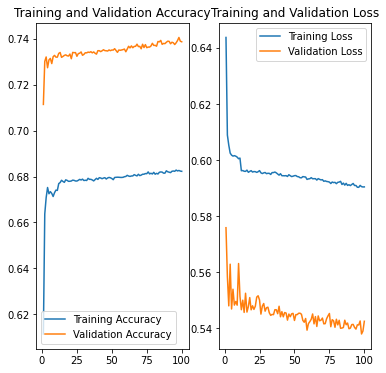

In [22]:
loss=history.history['loss']
val_loss=history.history['val_loss']

mae = history.history['accuracy']
val_mae = history.history['val_accuracy']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range[0:], mae[0:], label='Training Accuracy')
plt.plot(epochs_range[0:], val_mae[0:], label='Validation Accuracy')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range[:], loss[:], label='Training Loss')
plt.plot(epochs_range[:], val_loss[:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
test_loss, test_acc = model.evaluate( [test['points'],test['features']], test['label'], verbose=2, batch_size = batch_size)

782/782 - 6s - loss: 0.5421 - accuracy: 0.7398


In [24]:
model.load_weights("model_checkpoints/simple_GCN_on_Tau_Trk+Cls.h5")#DGCNN_on_Tau.h5

In [25]:
test_loss, test_acc = model.evaluate( [test['points'],test['features']], test['label'], verbose=2, batch_size = batch_size)

782/782 - 6s - loss: 0.5375 - accuracy: 0.7413


### ROC curve

In [44]:
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

In [45]:
predicted_data = model.predict([test['points'],test['features'],test['Glob_features']], batch_size = batch_size, verbose = 1)

KeyError: 'Glob_features'

In [ ]:
# calculate precision and recall
# True Positive
tp = len(test['label'][(test['label'] == 0) & (predicted_data == 0)])
# False Positive -- predict anomaly (-1), when it is actually normal (1)
fp = len(test['label'][(test['label'] == 1) & (predicted_data == 0)])
# True Negative
tn = len(test['label'][(test['label'] == 1) & (predicted_data == 1)])
# False Negative
fn = len(test['label'][(test['label'] == 0) & (predicted_data == 1)])

In [ ]:
# precision/recall
pre_score = tp / (tp + fp)
re_score = tp / (tp + fn)
# tpr/fpr
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

### Study of dataset

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


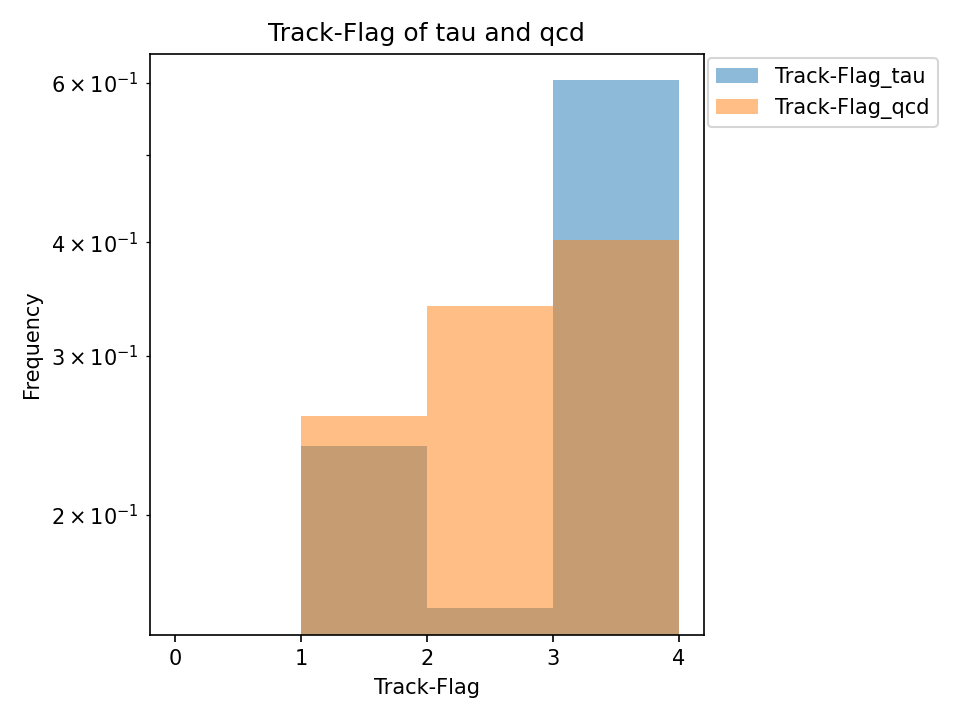

In [5]:
set_variable = ['DeltaEta', 'DeltaPhi', 'Pt', 'E', 'd0', 'z0', 'theta', 'Track-Flag']
mask = [-9, -9, -999, -999, -999, -999, -999, -9]
xlow = [-0.7, -0.7, 0, 0, -200, -300, 0, 0]
xup = [0.7, 0.7, 10**9, 10**9, 200, 300, 3.25, 4]
setted_var = 7 #btw 0 and 3
#cleaning of variable from mask and values bigger than 10**9
a = array_tau[:,:,setted_var]#
b = array_qcd[:,:,setted_var]#test['features']
c =  (a != mask[setted_var])
d =  (b != mask[setted_var])
a = a[c]
b = b[d]

n_bins=4
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(a, bins=n_bins , label=set_variable[setted_var]+'_tau', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
ax1.hist(b, bins=n_bins , label=set_variable[setted_var]+'_qcd', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and qcd")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')

In [51]:
array_tau = np.load('ntuples/dataset_tau.npy')
selected_class = 1
classes = [-9.00000000e+00,1.00000000e+00, 2.00000000e+00, 3.00000000e+00, None]
#cleaning of variable from mask
tau_dEta = array_tau[:,:,0]
tau_dPhi = array_tau[:,:,1]
c =  (tau_dEta != -9)
dR = np.ones(c.shape) - 3

for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        if c[i,j] and array_tau[i,j,7] == classes[selected_class] :
            dR[i,j] = np.sqrt( tau_dEta[i,j]**2 + tau_dPhi[i,j]**2 )
dR = np.reshape(dR, c.shape[0]*c.shape[1])

Text(0, 0.5, 'Frequency')

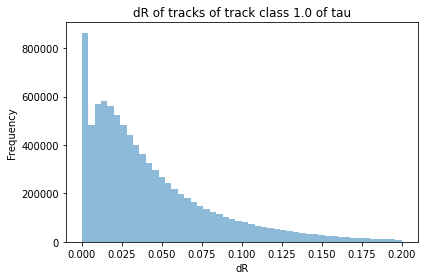

In [52]:
xlow = [0, 0, 0, 0, 0]
xup = [0, 0.2, 0.5, 0.6, 0.6] #class 1 arrives until 0.55
n_bins=50

c = dR != -2
dR = dR[c]

fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
#To normalize histograms we set density=True, to get area = 1
ax.hist(dR, bins=n_bins , lw=0.5, alpha=0.5, range=[xlow[selected_class], xup[selected_class]] )
plt.title("dR of tracks of track class "+str(classes[selected_class])+" of tau")
plt.xlabel("dR")
plt.ylabel("Frequency")
#ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#ax.set_yscale('log')
#ax1.set_yscale('log')

Number of true trcks

In [11]:
array_tau = np.load('ntuples/dataset_tau.npy')
a = array_tau[:,:,2]
c =  (a != -999)
d = np.zeros(c.shape[0])
for i in range(c.shape[0]):
    track_counter = 0
    for j in range(10):
        if c[i,j]:
            track_counter +=1
    d[i] = track_counter

<IPython.core.display.Javascript object>


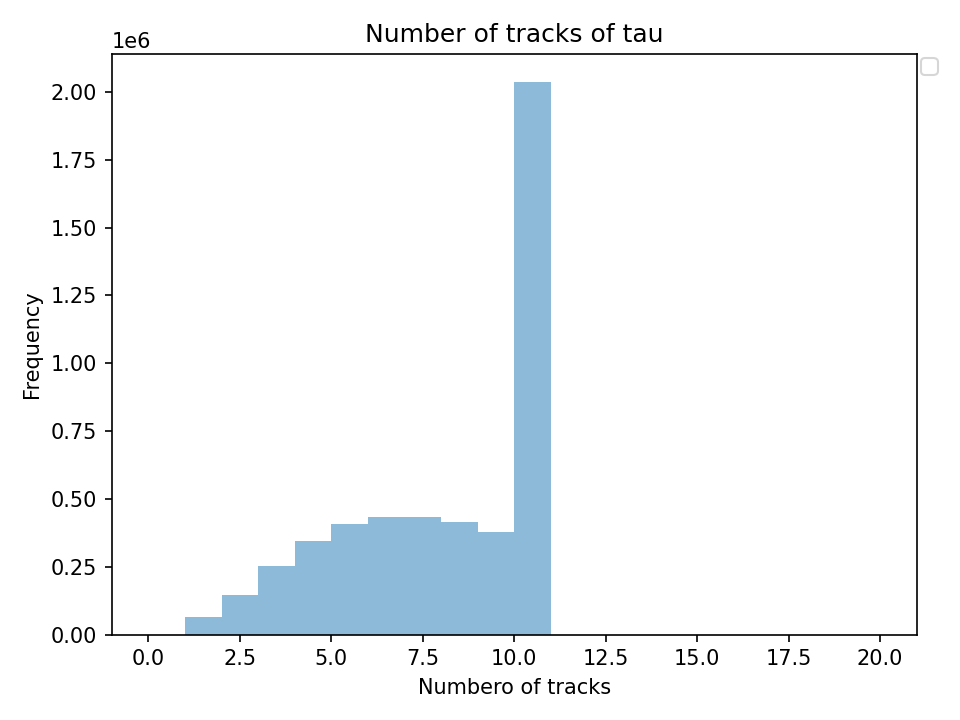

No handles with labels found to put in legend.


In [15]:
n_bins=20
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
#To normalize histograms we set density=True, to get area = 1
ax.hist(d, bins=n_bins , lw=0.5, alpha=0.5, range=[0, 20] )
plt.title("Number of tracks of tau")
plt.xlabel("Numbero of tracks")
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)

In [29]:
array_tau[14,:,2]

array([59483.84375   , 29547.41796875, 24985.03515625,  1819.86730957,
        1744.25976562,  1509.25500488,   829.10339355,  5041.61132812,
         672.88793945,   887.49542236])

In [30]:
array_tau[14,:,7]

array([1., 1., 1., 2., 2., 2., 2., 3., 3., 3.])

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))